In [2]:
%autosave 60
%matplotlib inline

import python_preamble

Autosaving every 60 seconds


In [20]:
df = pd.read_csv(os.path.join(data_folder + "/input/main_upd5.csv"), encoding="utf-8", sep=";")
df.date = pd.to_datetime(df.date).dt.date
df.head()

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone
0,2010-01-11,0,О результатах мониторинга максимальных процент...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_133902...,0,NaN,801,3,137,0.094714,0.013910,-0.080804
1,2010-01-11,0,Об условиях проведения Банком России 11.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_104827...,0,NaN,553,2,77,0.181789,0.076406,-0.105383
2,2010-01-11,0,О проведении ломбардных кредитных аукционов,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_161453...,0,NaN,322,1,48,0.149605,0.085060,-0.064544
3,2010-01-12,0,Об условиях проведения Банком России 12.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_112503...,0,NaN,553,2,77,0.183338,0.077057,-0.106281
4,2010-01-12,0,Об итогах проведения ломбардных кредитных аукц...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_181233...,0,NaN,1726,6,281,0.250569,0.055870,-0.194700


# Добавляем остальные переменные метрики

In [21]:
# df_temp = df[df.rate_flag == 1]
# plt.scatter(df_temp.date, df_temp['positive'] / (df_temp['positive'] + df_temp['negative']) )
# df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
# plt.scatter(df_temp.date, df_temp['positive'] / (df_temp['positive'] + df_temp['negative']) )

## Ключевая ставка

In [22]:
months = {"января": "01",
"февраля": "02",
"марта": "03",
"апреля": "04",
"мая": "05",
"июня": "06",
"июля": "07",
"августа": "08",
"сентября": "09",
"октября": "10",
"ноября": "11",
"декабря": "12"}

In [23]:
df_rate = pd.read_csv(os.path.join(data_folder + "/input/key_rate.csv"))
df_rate['announced_date'] = pd.to_datetime(df_rate['announced_date'], format="%d.%m.%Y").dt.date
dates = []
for i in df_rate.actual_date:
    l = i.split()
    dates.append(l[0]+"."+months[l[1]]+"."+l[2])
df_rate['actual_date'] = dates
df_rate['actual_date'] = pd.to_datetime(df_rate['actual_date'], format="%d.%m.%Y").dt.date
df_rate['rate'] = df_rate['rate'].str.replace(",",".").astype(float)

In [24]:
df_short = df[(df.date >= datetime.date(2013, 9, 13)) & (df.rate_flag == 1)].reset_index(drop=True)

announced_rates = dict(df_rate[['announced_date','rate']].to_numpy())
# df_short.date.apply(lambda x: announced_rates[x])
all_dates = pd.DataFrame(np.arange(df_short.date.min(), df_short.date.max()+datetime.timedelta(1)), columns = ['date'])
df_announced_rates = all_dates.copy()

curmin = min(list(announced_rates.keys()))
r = [announced_rates.pop(curmin)]
for d in all_dates.date[1:]:
    curmin2 = min(list(announced_rates.keys()))
    if d >= curmin2:
        curmin = curmin2
        r.append(announced_rates.pop(curmin))
    else:
        r.append(r[-1])
df_announced_rates['rate'] = r

actual_rates = dict(df_rate[['actual_date','rate']].to_numpy())
df_real_rates = all_dates.copy()
curmin = min(list(actual_rates.keys()))
r = [actual_rates.pop(curmin)]
for d in all_dates.date[1:]:
    curmin2 = min(list(actual_rates.keys()))
    if d >= curmin2:
        curmin = curmin2
        r.append(actual_rates.pop(curmin))
    else:
        r.append(r[-1])
df_real_rates['rate'] = r

df_rates = pd.merge(df_announced_rates, df_real_rates, left_on="date", right_on='date', suffixes=("_announced", "_real"))
df_rates['date'] = df_rates['date'].dt.date
df_rates.tail()

df_short = pd.merge(df_short, df_rates, how="left", left_on="date", right_on='date')
df_short['rate_shock_abs'] = df_short.rate_announced - df_short.rate_real
df_short['rate_shock_rel'] = df_short.rate_shock_abs / df_short.rate_real
# df_short = df_short[(df_short.date > datetime.date(2013, 9, 13))].reset_index(drop=True)
df_short.tail(3)

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone,rate_announced,rate_real,rate_shock_abs,rate_shock_rel
108,2021-10-22,0,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 22 октября 2021 ...,https://www.cbr.ru/press/pr/?file=22102021_133...,1,NaN,9046,71,1276,0.187382,0.061726,-0.125656,7.5,6.75,0.75,0.111111
109,2021-12-17,1,Заявление Председателя Банка России Эльвиры На...,Добрый день! Мы приняли решение повысить ключе...,https://www.cbr.ru/press/event/?id=12542,1,Добрый день! Мы приняли решение повысить ключе...,25807,228,4279,0.243268,0.092965,-0.150303,8.5,7.50,1.00,0.133333
110,2021-12-17,0,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 17 декабря 2021 ...,https://www.cbr.ru/press/pr/?file=17122021_133...,1,NaN,8486,65,1188,0.202485,0.058289,-0.144196,8.5,7.50,1.00,0.133333


In [25]:
df_short.loc[(df_short.date == datetime.date(2013, 9, 13)), "rate_shock_abs"] = \
    df_short.loc[(df_short.date == datetime.date(2013, 9, 13)), "rate_real"]

In [26]:
df_short[df_short.rate_flag ==1].groupby("type")['date'].count()

type
0    70
1    41
Name: date, dtype: int64

In [27]:
df_short.rate_shock_abs.unique()

array([ 5.5 ,  0.  ,  0.5 ,  1.5 ,  1.  , -2.  , -1.  , -1.5 , -0.5 ,
       -0.25,  0.25,  0.75])

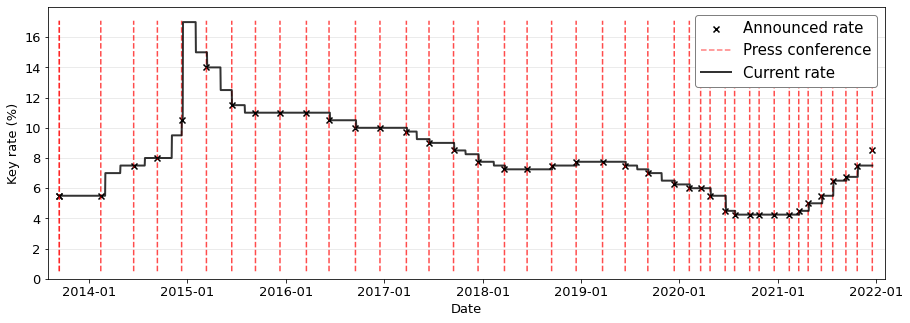

In [28]:
# font = FontProperties()
# font.set_family('serif')
# font.set_name('Calibri')
# font.set_style('italic')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))


# y_ver = np.arange(2, 16)
y_ver = np.arange(0.5, 17.1, 0.01)
ax.scatter([datetime.date(2013, 9, 13)],[5.5], color='black', label='Announced rate', marker="x")
ax.plot([datetime.date(2013, 9, 13)] * y_ver.shape[0], y_ver, color = 'r', alpha=0.5, linestyle="--", 
        label='Press conference')
for i, j in  df_short[df_short.type == 1][["date", "rate_announced"]].to_numpy():
    ax.plot([i] * y_ver.shape[0], y_ver, color = 'r', alpha=0.7, linestyle="--")
    ax.scatter([i],[j], color='black', marker="x")
    
sns.lineplot(x = df_rates.date, y = df_rates.rate_real, color = 'black',label="Current rate", alpha=0.8, linewidth=2)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Key rate (%)', fontsize=13)
plt.xlim((datetime.date(2013, 8, 1), datetime.date(2022, 2, 1)))
plt.ylim(0, 18)
ax.yaxis.set_ticks(np.arange(0, 17, 2))
ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.grid(axis='y', alpha=0.3)
fig.patch.set_facecolor('white')
plt.show()

D:\Users\User\anaconda3\lib\site-packages\seaborn\relational.py:608: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
D:\Users\User\anaconda3\lib\site-packages\seaborn\relational.py:658: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


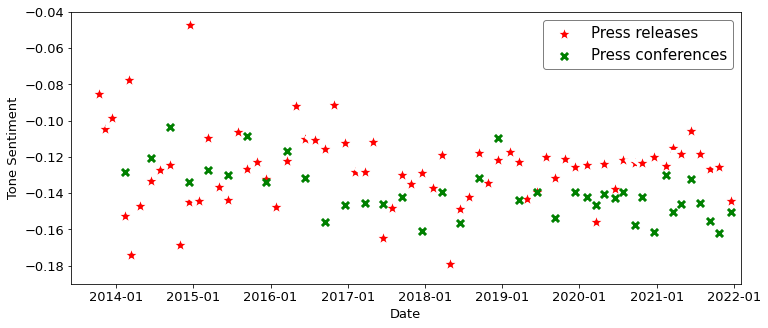

In [29]:
# события - первая версия

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df_temp = df_short[(df_short.date > datetime.date(2013, 9, 13)) & (df_short.type==0)]
sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=1, s=400, color='r', linewidth=3, marker="*", 
                label='Press releases', edgecolors='none')
df_temp = df_short[(df_short.date > datetime.date(2013, 9, 13)) & (df_short.type==1)]
sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=1, s=50, color='g', linewidth=3, marker="x",
                label='Press conferences', edgecolors='none')

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Tone Sentiment', fontsize=13)

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)

fig.patch.set_facecolor('white')

plt.xlim((datetime.date(2013, 6, 1), datetime.date(2022, 2, 1)))
plt.ylim((-0.19, -0.04))

ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ax.grid(axis='y', alpha=0.3)
plt.show()

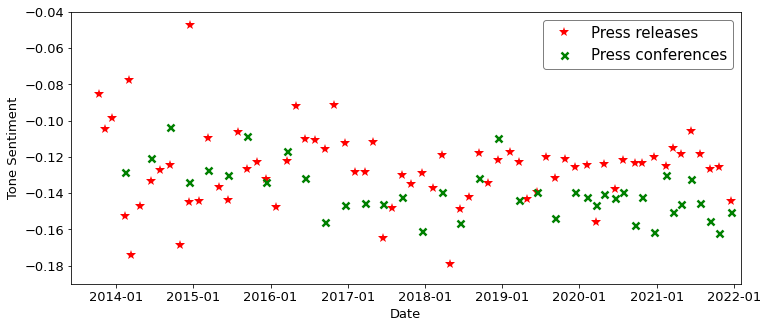

In [30]:
# события - вторая версия

fig, ax = plt.subplots(1, 1, figsize=(12, 5))


df_temp = df_short[(df_short.date > datetime.date(2013, 9, 13)) & (df_short.type==0)]
plt.plot(df_temp.date, df_temp.tone, '*', markersize=10, markerfacecolor='red',
         markeredgecolor='black', markeredgewidth=0.0,label='Press releases',)

df_temp = df_short[(df_short.date > datetime.date(2013, 9, 13)) & (df_short.type==1)]
plt.plot(df_temp.date, df_temp.tone, 'x', markersize=7, markerfacecolor='green',
         markeredgecolor='green', markeredgewidth=2.5,label='Press conferences',)

# sns.scatterplot(, alpha=1, s=400, color='r', linewidth=3, marker="*", 
#                 label='Press releases', edgecolors='none')
# sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=1, s=50, color='g', linewidth=3, marker="x",
#                 label='Press conferences', edgecolors='none')

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Tone Sentiment', fontsize=13)

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)

fig.patch.set_facecolor('white')

plt.xlim((datetime.date(2013, 6, 1), datetime.date(2022, 2, 1)))
plt.ylim((-0.19, -0.04))

ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ax.grid(axis='y', alpha=0.3)
plt.savefig(os.path.join(materials_folder + "/pics/pic4.png"), dpi=300)
plt.show()

## Добавляем контроль на доверие и трансперенси 
(клеим к конкретному датасету/ спецификации)

In [31]:
dftrust = pd.read_csv(os.path.join(data_folder + "/input/trust.csv"))
dftrust.columns = ['year', 'skip', 'idk', 'not', 'do']
dftrust.head(1)

,year,skip,idk,not,do
0,2014,30,20,14,36


In [32]:
dftrans = pd.read_csv(os.path.join(data_folder + "/input/CBT-IT.csv"))
dftrans.head(1)

,year,index
0,2013,3.5


In [33]:
df_short.head(1)

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone,rate_announced,rate_real,rate_shock_abs,rate_shock_rel
0,2013-09-13,1,Информация по итогам брифинга Председателя Бан...,"Добрый день, уважаемые коллеги. Я хочу рассказ...",https://www.cbr.ru/press/event/?id=5196,1,"Добрый день, уважаемые коллеги. Я хочу рассказ...",32388,285,5406,0.208317,0.08475,-0.123568,5.5,5.5,5.5,0.0


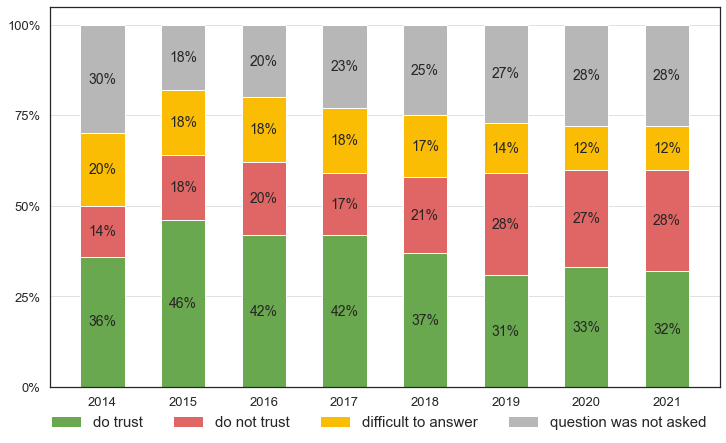

In [34]:
# chart
sns.set(style='white')

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

width = 0.55
p = ax.bar(dftrust.year, dftrust.do, width, label='do trust', color='#6aa84f',edgecolor=None)
ax.bar_label(p, labels = [str(i) +'%' for i in p.datavalues],
            label_type='center', fontsize=14)

p = ax.bar(dftrust.year, dftrust['not'], width, bottom=dftrust.do, label='do not trust', 
           color='#e06666', edgecolor=None)
ax.bar_label(p, labels = [str(i) +'%' for i in p.datavalues],
            label_type='center', fontsize=14)

p = ax.bar(dftrust.year, dftrust.idk, width, bottom=dftrust.do+dftrust['not'], label='difficult to answer', 
           color='#fbbc04', edgecolor=None)
ax.bar_label(p, labels = [str(i) +'%' for i in p.datavalues],
            label_type='center', fontsize=14)

p = ax.bar(dftrust.year, dftrust.skip, width, bottom=dftrust.do+dftrust['not']+dftrust.idk,
           label='question was not asked', color='#b7b7b7', edgecolor=None)
ax.bar_label(p, labels = [str(i) +'%' for i in p.datavalues],
             label_type='center', fontsize=14)

# ax.set_xlabel('Date', fontsize=13)
# ax.set_ylabel('Tone Sentiment', fontsize=13)

legend = plt.legend(bbox_to_anchor=(1, -.04),loc="upper right",
                    edgecolor="w", fontsize=15, ncol=len(dftrust.columns))
legend.get_frame().set_alpha(None)


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.set_yticks([i*25 for i in range(0, 5)])
ax.set_yticklabels([f'{i*25}%' for i in range(0, 5)])

ax.grid(axis='y', alpha=0.6)
plt.savefig(os.path.join(materials_folder + "/pics/chart.png"), dpi=300)
plt.show()

## Outcome Variables

#### MOEX

In [86]:
dfm = pd.read_csv(os.path.join(data_folder + "/input/imoex.csv"))
dfm['TRADEDATE'] = pd.to_datetime(dfm['TRADEDATE'], format="%d.%m.%Y").dt.date
dfm = dfm.sort_values(by='TRADEDATE')

for col in dfm.columns[-5:]:
    dfm[col] = dfm[col].str.replace(",", ".").astype(float)

# dfm.CLOSE = dfm.CLOSE / dfm.OPEN[0]    
# dfm.OPEN = dfm.OPEN / dfm.OPEN[0]
dfm.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE
0,SNDX,IMOEX,2010-01-11,Индекс МосБиржи,Индекс МосБиржи,1444.78,1370.30,1456.78,1370.30,5.205232e+10
1,SNDX,IMOEX,2010-01-12,Индекс МосБиржи,Индекс МосБиржи,1427.67,1444.78,1445.70,1424.73,3.882154e+10
2,SNDX,IMOEX,2010-01-13,Индекс МосБиржи,Индекс МосБиржи,1435.01,1427.62,1444.86,1412.87,4.222875e+10
3,SNDX,IMOEX,2010-01-14,Индекс МосБиржи,Индекс МосБиржи,1455.65,1435.01,1456.34,1435.01,4.451159e+10
4,SNDX,IMOEX,2010-01-15,Индекс МосБиржи,Индекс МосБиржи,1452.67,1455.47,1469.55,1448.68,4.267554e+10


In [87]:
dfm.isna().any()

BOARDID      False
SECID        False
TRADEDATE    False
SHORTNAME    False
NAME         False
CLOSE        False
OPEN         False
HIGH         False
LOW          False
VALUE        False
dtype: bool

In [88]:
(dfm.iloc[:, -5:] == 0).any()

CLOSE    False
OPEN     False
HIGH     False
LOW      False
VALUE     True
dtype: bool

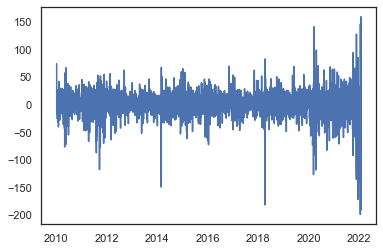

In [89]:
# SPREAD СЛАБО ПОДХОДИТ!
dfm['SPREAD'] = dfm['CLOSE'] - dfm['OPEN']
plt.plot(dfm.TRADEDATE, dfm.SPREAD)
plt.show()

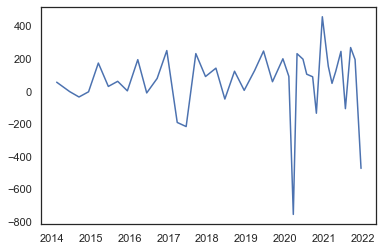

In [90]:
df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
df_temp = pd.merge(df_temp, dfm[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], 
                   how='left', left_on='date', right_on='TRADEDATE')
# df_temp.groupby("date")['url'].count().sort_values()
df_temp.head(3)
a = df_temp.CLOSE.tolist()[:-1]
df_temp = df_temp.iloc[1:]
df_temp['CLOSE_1'] = a
df_temp['CLOSE_SPREAD'] = df_temp['CLOSE'] - df_temp['CLOSE_1']
plt.plot(df_temp.TRADEDATE, df_temp.CLOSE_SPREAD)
plt.show()

In [91]:
# model = smf.ols('CLOSE ~ tone', data=df_temp).fit()
# print(model.summary())

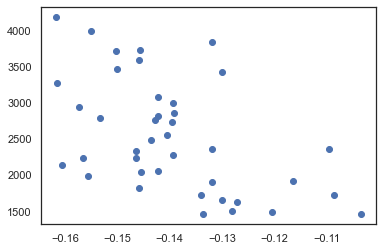

In [92]:
# важн
Y = df_temp['CLOSE']
X = df_temp.tone
plt.scatter(X, Y)
plt.show()

In [93]:
# df_short1 = pd.merge(df_short, dfm[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], 
#          how='left', left_on='date', right_on='TRADEDATE').drop(columns=['TRADEDATE'])
# df_short1 = df_short1.rename(columns={"OPEN":"moex_open","CLOSE":"moex_close","SPREAD":"moex_spread"})
# df_short1.head(1)

In [94]:
# model = smf.ols('moex_close ~ tone', data=df_short1).fit()
# # print(model.summary())

In [95]:
# # важн
# Y = df_short1['moex_close']
# X = df_short1.tone
# sns.scatterplot(X, Y)
# plt.show()

In [96]:
# # тональность не зависит от шока!
# # но немного зависит от анонсированной ставки...
# sns.scatterplot(x=df_short.tone, y=df_short.rate_shock_abs)
# model = smf.ols('tone ~ rate_announced', data=df_short).fit()
# print(model.summary())
# plt.show()

#### RTS

In [97]:
dfr = pd.read_csv(os.path.join(data_folder + "/input/rtsi.csv"))
dfr['TRADEDATE'] = pd.to_datetime(dfr['TRADEDATE'], format="%d.%m.%Y").dt.date
dfr = dfr.sort_values(by='TRADEDATE')

for col in dfr.columns[-5:]:
    dfr[col] = dfr[col].str.replace(",", ".").astype(float)

# dfr.CLOSE = dfr.CLOSE / dfr.OPEN[0]    
# dfr.OPEN = dfr.OPEN / dfr.OPEN[0]
dfr.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE
0,RTSI,RTSI,2010-01-11,Индекс РТС,Индекс РТС,1553.06,1444.70,1561.80,1444.70,3.201883e+08
1,RTSI,RTSI,2010-01-12,Индекс РТС,Индекс РТС,1535.78,1550.20,1559.75,1528.09,3.482365e+08
2,RTSI,RTSI,2010-01-13,Индекс РТС,Индекс РТС,1538.43,1535.78,1548.46,1512.81,3.408507e+08
3,RTSI,RTSI,2010-01-14,Индекс РТС,Индекс РТС,1561.91,1538.37,1561.91,1538.22,2.945995e+08
4,RTSI,RTSI,2010-01-15,Индекс РТС,Индекс РТС,1559.25,1561.91,1573.90,1553.83,3.889666e+08


In [98]:
# # SPREAD СЛАБО ПОДХОДИТ!
# dfr['SPREAD'] = dfr['CLOSE'] - dfr['OPEN']
# plt.plot(dfr.TRADEDATE, dfr.SPREAD)
# plt.show()

dfr.isna().any(), (dfr.iloc[:, -5:] == 0).any()

(BOARDID      False
 SECID        False
 TRADEDATE    False
 SHORTNAME    False
 NAME         False
 CLOSE        False
 OPEN         False
 HIGH         False
 LOW          False
 VALUE        False
 dtype: bool,
 CLOSE    False
 OPEN     False
 HIGH     False
 LOW      False
 VALUE    False
 dtype: bool)

In [99]:
# df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
# df_temp = pd.merge(df_temp, dfr[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
# # df_temp.groupby("date")['url'].count().sort_values()
# df_temp.head(3)

In [100]:
# model = smf.ols('CLOSE ~ tone', data=df_temp).fit()
# print(model.summary())

In [101]:
# df_short2 = pd.merge(df_short1, dfm[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], 
#          how='left', left_on='date', right_on='TRADEDATE').drop(columns=['TRADEDATE'])
# df_short2 = df_short2.rename(columns={"OPEN":"rts_open","CLOSE":"rts_close","SPREAD":"rts_spread"})
# df_short2.head(1)

In [102]:
# df_short2.to_csv("final01.csv", encoding="utf-8", sep=";", index=False)

#### FXGD

In [103]:
dfg = pd.read_csv(os.path.join(data_folder + "/input/FXGD.csv"))
dfg['date'] = dfg['date'].str.replace(" ","-")
dfg['date'] = [i[:6] + "20" + i[6:] for i in dfg['date']]
dfg['date'] = pd.to_datetime(dfg['date'], format="%d-%m-%Y").dt.date
dfg = dfg.sort_values(by='date').reset_index(drop=True)

for col in dfg.columns[1:]:
    dfg[col] = dfg[col].str.replace(",", ".").str.replace("-", "0").astype(float)

# dfg['CLOSE_norm'] = dfg.CLOSE / dfg.OPEN[0]    
# dfg.OPEN = dfg.OPEN / dfg.OPEN[0]
dfg.head()

,date,OPEN,MIN,MAX,CLOSE,"VOLUME, RUB","NAV, USD"
0,2013-12-16,29.15,29.15,29.24,29.24,17534.7,3707016.01
1,2013-12-17,29.47,29.22,29.47,29.26,117289.8,3730346.36
2,2013-12-18,29.26,29.20,29.26,29.20,195823.8,3718235.31
3,2013-12-19,29.14,28.48,29.14,28.55,4560176.1,3633734.05
4,2013-12-20,28.46,28.37,28.46,28.43,482856.9,3602772.54


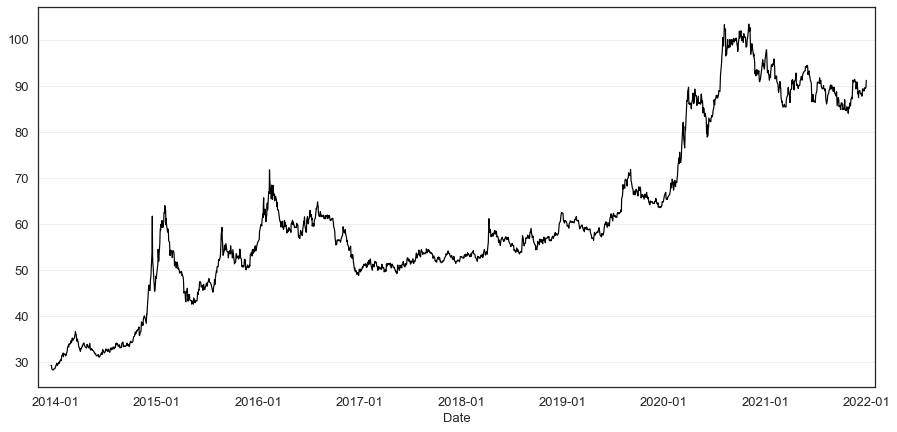

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))


sns.lineplot(x = dfg[dfg.date < datetime.date(2022, 1, 1)].date, 
             y = dfg[dfg.date < datetime.date(2022, 1, 1)].CLOSE, color = 'black', alpha=1, linewidth=1.2)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('', fontsize=13)
plt.xlim((datetime.date(2013, 11, 1), datetime.date(2022, 2, 1)))

ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])

# legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
# legend.get_frame().set_alpha(None)
# # legend.get_frame().set_facecolor((0, 0, 1, 0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.grid(axis='y', alpha=0.3)
fig.patch.set_facecolor('white')
plt.show()

# df_short3 = pd.merge(df_short2, dfg[["date", "CLOSE_norm", ]], 
#          how='left', left_on='date', right_on='date')
# df_short3 = df_short3.rename(columns={"CLOSE_norm":"gold_close",})

### Bonds

#### RGBITR & RUCBITR

In [105]:
df_rgbitr = pd.read_csv(os.path.join(data_folder + "/input/bonds - RGBITR.csv"), sep=",")
df_rgbitr['date'] = df_rgbitr['date'].str.replace(" ","-")
df_rgbitr['date'] = [i[:6] + "20" + i[6:] for i in df_rgbitr['date']]
df_rgbitr['date'] = pd.to_datetime(df_rgbitr['date'], format="%d-%m-%Y").dt.date
df_rgbitr = df_rgbitr.sort_values(by='date').reset_index(drop=True)
df_rgbitr.head(3)

,date,OPEN,MAX,MIN,CLOSE,VOLUME,CAP,DURATION,YIELD
0,2013-01-08,313.36,313.36,312.91,312.91,7 258,0.00,0.00,6.79
1,2013-01-09,312.10,314.60,311.91,314.60,1 304 425 877,0.00,0.00,6.54
2,2013-01-10,315.01,317.48,314.99,317.48,2 935 642 331,0.00,0.00,6.36


In [106]:
df_RUCBITR = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUCBITR.csv"), sep=",")
df_RUCBITR['date'] = df_RUCBITR['date'].str.replace(" ","-")
df_RUCBITR['date'] = [i[:6] + "20" + i[6:] for i in df_RUCBITR['date']]
df_RUCBITR['date'] = pd.to_datetime(df_RUCBITR['date'], format="%d-%m-%Y").dt.date
df_RUCBITR = df_RUCBITR.sort_values(by='date').reset_index(drop=True)
df_RUCBITR.head(3)

,date,OPEN,MAX,MIN,CLOSE,VOLUME,CAP,DURATION,YIELD
0,2013-01-08,224.60,224.60,224.54,224.55,784 691,715 338 189 325,856.00,8.63
1,2013-01-09,224.55,224.61,224.55,224.57,7 721 771 992,715 389 374 325,855.00,8.64
2,2013-01-10,224.63,224.77,224.60,224.71,2 202 431 535,715 402 294 352,854.00,8.63


#### RUGBITR1Y & RUGBITR3Y & RUGBITR5Y & RUGBITR10Y & RUABITR

In [107]:
df_RUGBITR1Y = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUGBITR1Y.csv"), sep=",")[["date", "CLOSE"]]
df_RUGBITR1Y['date'] = df_RUGBITR1Y['date'].str.replace(" ","-")
df_RUGBITR1Y['date'] = [i[:6] + "20" + i[6:] for i in df_RUGBITR1Y['date']]
df_RUGBITR1Y['date'] = pd.to_datetime(df_RUGBITR1Y['date'], format="%d-%m-%Y").dt.date
df_RUGBITR1Y = df_RUGBITR1Y.sort_values(by='date').reset_index(drop=True)
df_temp = pd.DataFrame([df_RUGBITR1Y['date'][:-1].values, df_RUGBITR1Y['CLOSE'][1:].values]).T
df_temp.columns = df_RUGBITR1Y.columns
df_RUGBITR1Y = pd.merge(df_temp, df_RUGBITR1Y.iloc[:-1], how='left', left_on="date", right_on="date")
df_RUGBITR1Y.columns = ["date", "CLOSE", "OPEN"]
df_RUGBITR1Y.head(3)

,date,CLOSE,OPEN
0,2013-01-08,111.69,111.68
1,2013-01-09,111.67,111.69
2,2013-01-10,111.71,111.67


In [108]:
df_RUGBITR3Y = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUGBITR3Y.csv"), sep=",")[["date", "CLOSE"]]
df_RUGBITR3Y['date'] = df_RUGBITR3Y['date'].str.replace(" ","-")
df_RUGBITR3Y['date'] = [i[:6] + "20" + i[6:] for i in df_RUGBITR3Y['date']]
df_RUGBITR3Y['date'] = pd.to_datetime(df_RUGBITR3Y['date'], format="%d-%m-%Y").dt.date
df_RUGBITR3Y = df_RUGBITR3Y.sort_values(by='date').reset_index(drop=True)
df_temp = pd.DataFrame([df_RUGBITR3Y['date'][:-1].values, df_RUGBITR3Y['CLOSE'][1:].values]).T
df_temp.columns = df_RUGBITR3Y.columns
df_RUGBITR3Y = pd.merge(df_temp, df_RUGBITR3Y.iloc[:-1], how='left', left_on="date", right_on="date")
df_RUGBITR3Y.columns = ["date", "CLOSE", "OPEN"]
df_RUGBITR3Y.head(3)

,date,CLOSE,OPEN
0,2013-01-08,299.26,298.90
1,2013-01-09,300.13,299.26
2,2013-01-10,300.65,300.13


In [109]:
df_RUGBITR5Y = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUGBITR5Y.csv"), sep=",")[["date", "CLOSE"]]
df_RUGBITR5Y['date'] = df_RUGBITR5Y['date'].str.replace(" ","-")
df_RUGBITR5Y['date'] = [i[:6] + "20" + i[6:] for i in df_RUGBITR5Y['date']]
df_RUGBITR5Y['date'] = pd.to_datetime(df_RUGBITR5Y['date'], format="%d-%m-%Y").dt.date
df_RUGBITR5Y = df_RUGBITR5Y.sort_values(by='date').reset_index(drop=True)
df_temp = pd.DataFrame([df_RUGBITR5Y['date'][:-1].values, df_RUGBITR5Y['CLOSE'][1:].values]).T
df_temp.columns = df_RUGBITR5Y.columns
df_RUGBITR5Y = pd.merge(df_temp, df_RUGBITR5Y.iloc[:-1], how='left', left_on="date", right_on="date")
df_RUGBITR5Y.columns = ["date", "CLOSE", "OPEN"]
df_RUGBITR5Y.head(3)

,date,CLOSE,OPEN
0,2013-01-08,313.69,312.01
1,2013-01-09,315.55,313.69
2,2013-01-10,315.63,315.55


In [110]:
df_RUGBITR10Y = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUGBITR10Y.csv"), sep=",")[["date", "CLOSE"]]
df_RUGBITR10Y['date'] = df_RUGBITR10Y['date'].str.replace(" ","-")
df_RUGBITR10Y['date'] = [i[:6] + "20" + i[6:] for i in df_RUGBITR10Y['date']]
df_RUGBITR10Y['date'] = pd.to_datetime(df_RUGBITR10Y['date'], format="%d-%m-%Y").dt.date
df_RUGBITR10Y = df_RUGBITR10Y.sort_values(by='date').reset_index(drop=True)
df_temp = pd.DataFrame([df_RUGBITR10Y['date'][:-1].values, df_RUGBITR10Y['CLOSE'][1:].values]).T
df_temp.columns = df_RUGBITR10Y.columns
df_RUGBITR10Y = pd.merge(df_temp, df_RUGBITR10Y.iloc[:-1], how='left', left_on="date", right_on="date")
df_RUGBITR10Y.columns = ["date", "CLOSE", "OPEN"]
df_RUGBITR10Y.head(3)

,date,CLOSE,OPEN
0,2013-01-08,319.72,317.62
1,2013-01-09,324.17,319.72
2,2013-01-10,322.85,324.17


In [111]:
df_RUABITR = pd.read_csv(os.path.join(data_folder + "/input/bonds - RUABITR.csv"), sep=",")[["date", "CLOSE"]]
df_RUABITR['date'] = df_RUABITR['date'].str.replace(" ","-")
df_RUABITR['date'] = [i[:6] + "20" + i[6:] for i in df_RUABITR['date']]
df_RUABITR['date'] = pd.to_datetime(df_RUABITR['date'], format="%d-%m-%Y").dt.date
df_RUABITR = df_RUABITR.sort_values(by='date').reset_index(drop=True)
df_temp = pd.DataFrame([df_RUABITR['date'][:-1].values, df_RUABITR['CLOSE'][1:].values]).T
df_temp.columns = df_RUABITR.columns
df_RUABITR = pd.merge(df_temp, df_RUABITR.iloc[:-1], how='left', left_on="date", right_on="date")
df_RUABITR.columns = ["date", "CLOSE", "OPEN"]
df_RUABITR.head(3)

,date,CLOSE,OPEN
0,2013-01-08,120.18,119.89
1,2013-01-09,120.97,120.18
2,2013-01-10,120.96,120.97


# Final Datasets

In [112]:
# dfm['SPREAD'] = np.log(dfm.CLOSE) - np.log(dfm.OPEN)
# df_temp = pd.merge(df_short[df_short.type==1][['date','tone']], 
#                    dfm[["TRADEDATE", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
# df_temp = df_temp.drop(columns=['TRADEDATE']).rename(columns={'CLOSE':"moex_close", "SPREAD":"moex_spread"})

# # df_temp.to_csv(os.path.join(data_folder + "/final01.csv"), encoding="utf-8", sep=";", index=False)

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# sns.scatterplot(y=df_temp['moex_close'],x=df_temp.tone, ax=axs[0])
# sns.scatterplot(y=df_temp['moex_spread'],x=df_temp.tone, ax=axs[1])

# plt.show()

In [113]:
# dfm['SPREAD'] = np.log(dfm.CLOSE) - np.log(dfm.OPEN)
# df_temp = pd.merge(df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']], 
#                    dfm[["TRADEDATE", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
# df_temp = df_temp.drop(columns=['TRADEDATE']).rename(columns={'CLOSE':"moex_close", 
#                                                               "SPREAD":"moex_spread",
#                                                               "tone":"tonepr"})

# df_temp = pd.merge(df_temp, df_short[df_short.type==1][['date','tone']], 
#                    how='left', left_on='date', right_on='date').rename(columns={"tone":"toneev"})

# # df_temp.to_csv(os.path.join(data_folder + "/final01.csv"), encoding="utf-8", sep=";", index=False)
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# sns.scatterplot(y=df_temp['moex_spread'],x=df_temp.tonepr, ax=axs[0])
# plt.show()

In [114]:
dfm['SPREAD'] = np.log(dfm.CLOSE) - np.log(dfm.OPEN)
df_temp = pd.merge(df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']], 
                   dfm[["TRADEDATE", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
df_temp = df_temp.drop(columns=['TRADEDATE']).rename(columns={'CLOSE':"moex_close", 
                                                              "SPREAD":"moex_spread",
                                                              "tone":"tonepr"})

df_temp = pd.merge(df_temp, df_short[df_short.type==1][['date','tone']], 
                   how='left', left_on='date', right_on='date').rename(columns={"tone":"toneev"})
df_temp['year'] = df_temp.date.apply(lambda x: x.year).astype(float)

transList = dict(dftrans.to_numpy())
df_temp['trans'] = df_temp['year'].apply(lambda x: transList[x])

dftrust['year'] = dftrust['year']
trustList = dict(dftrust[['year', 'do']].to_numpy())
df_temp['trust'] = df_temp['year'].apply(lambda x: trustList[x] if x in trustList else None) / 100

# test co-movement of tonepr and toneev
df_temp['tonepr2'] = np.power(df_temp['tonepr'], 2)
df_temp['tonepr3'] = np.power(df_temp['tonepr'], 3)

# df_temp.to_csv(os.path.join(data_folder + "/final00.csv"), encoding="utf-8", sep=";", index=False)

# remove 1st obs
df_temp = df_temp.iloc[1:].reset_index(drop=True)
df_temp.to_csv(os.path.join(data_folder + "/final01.csv"), encoding="utf-8", sep=";", index=False)

# df_temp[['toneev','trust']] = df_temp[['toneev','trust']].fillna(0)
# df_temp.to_csv(os.path.join(data_folder + "/final02.csv"), encoding="utf-8", sep=";", index=False)

df_temp['moex_spread'] = df_temp['moex_spread'] * 100
df_temp['tonepr'] = df_temp['tonepr'] / df_temp['tonepr'].std()
df_temp['toneev'] = df_temp['toneev'] / df_temp['toneev'].std()
df_temp.to_csv(os.path.join(data_folder + "/final01_normalized.csv"), encoding="utf-8", sep=";", index=False)

In [115]:
dfr['SPREAD'] = np.log(dfr.CLOSE) - np.log(dfr.OPEN)
df_temp = pd.merge(df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']], 
                   dfr[["TRADEDATE", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
df_temp = df_temp.drop(columns=['TRADEDATE']).rename(columns={'CLOSE':"rts_close", 
                                                              "SPREAD":"rts_spread",
                                                              "tone":"tonepr"})

df_temp = pd.merge(df_temp, df_short[df_short.type==1][['date','tone']], 
                   how='left', left_on='date', right_on='date').rename(columns={"tone":"toneev"})
df_temp['year'] = df_temp.date.apply(lambda x: x.year).astype(float)

transList = dict(dftrans.to_numpy())
df_temp['trans'] = df_temp['year'].apply(lambda x: transList[x])

dftrust['year'] = dftrust['year']
trustList = dict(dftrust[['year', 'do']].to_numpy())
df_temp['trust'] = df_temp['year'].apply(lambda x: trustList[x] if x in trustList else None) / 100

# df_temp.to_csv(os.path.join(data_folder + "/final10.csv"), encoding="utf-8", sep=";", index=False)

df_temp = df_temp.iloc[1:].reset_index(drop=True)
df_temp.to_csv(os.path.join(data_folder + "/final11.csv"), encoding="utf-8", sep=";", index=False)

# df_temp[['toneev','trust']] = df_temp[['toneev','trust']].fillna(0)
# df_temp.to_csv(os.path.join(data_folder + "/final12.csv"), encoding="utf-8", sep=";", index=False)

df_temp['rts_spread'] = df_temp['rts_spread'] * 100
df_temp['tonepr'] = df_temp['tonepr'] / df_temp['tonepr'].std()
df_temp['toneev'] = df_temp['toneev'] / df_temp['toneev'].std()
df_temp.to_csv(os.path.join(data_folder + "/final11_normalized.csv"), encoding="utf-8", sep=";", index=False)

In [116]:
dfg['SPREAD'] = np.log(dfg.CLOSE) - np.log(dfg.OPEN)

df_temp = pd.merge(df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']], 
                   dfg[["date", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='date')
df_temp = df_temp.rename(columns={'CLOSE':"gold_close", 
                                  "SPREAD":"gold_spread",
                                  "tone":"tonepr"})
df_temp = pd.merge(df_temp, df_short[df_short.type==1][['date','tone']], 
                   how='left', left_on='date', right_on='date').rename(columns={"tone":"toneev"})
df_temp['year'] = df_temp.date.apply(lambda x: x.year).astype(float)

transList = dict(dftrans.to_numpy())
df_temp['trans'] = df_temp['year'].apply(lambda x: transList[x])

dftrust['year'] = dftrust['year']
trustList = dict(dftrust[['year', 'do']].to_numpy())
df_temp['trust'] = df_temp['year'].apply(lambda x: trustList[x] if x in trustList else None) / 100

# df_temp.to_csv(os.path.join(data_folder + "/final20.csv"), encoding="utf-8", sep=";", index=False)

df_temp = df_temp.iloc[1:].reset_index(drop=True)
df_temp.to_csv(os.path.join(data_folder + "/final21.csv"), encoding="utf-8", sep=";", index=False)

df_temp['gold_spread'] = df_temp['gold_spread'] * 100
df_temp['tonepr'] = df_temp['tonepr'] / df_temp['tonepr'].std()
df_temp['toneev'] = df_temp['toneev'] / df_temp['toneev'].std()
df_temp.to_csv(os.path.join(data_folder + "/final21_normalized.csv"), encoding="utf-8", sep=";", index=False)

In [117]:
def data_mixer(df_, name):
    df_['CLOSE'] = df_['CLOSE'].astype(float)
    df_['OPEN'] = df_['OPEN'].astype(float)

    df_['SPREAD'] = np.log(df_.CLOSE) - np.log(df_.OPEN)

    df_temp = pd.merge(df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']], 
                       df_[["date", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='date')
    df_temp = df_temp.rename(columns={'CLOSE':"close", 
                                      "SPREAD":"spread",
                                      "tone":"tonepr"})
    df_temp = pd.merge(df_temp, df_short[df_short.type==1][['date','tone']], 
                       how='left', left_on='date', right_on='date').rename(columns={"tone":"toneev"})
    df_temp['year'] = df_temp.date.apply(lambda x: x.year).astype(float)

    transList = dict(dftrans.to_numpy())
    df_temp['trans'] = df_temp['year'].apply(lambda x: transList[x])

    dftrust['year'] = dftrust['year']
    trustList = dict(dftrust[['year', 'do']].to_numpy())
    df_temp['trust'] = df_temp['year'].apply(lambda x: trustList[x] if x in trustList else None) / 100


    df_temp = df_temp.iloc[1:].reset_index(drop=True)
    df_temp.iloc[:, -5] = df_temp.iloc[:, -5] * 100
    df_temp['tonepr'] = df_temp['tonepr'] / df_temp['tonepr'].std()
    df_temp['toneev'] = df_temp['toneev'] / df_temp['toneev'].std()
    df_temp.to_csv(os.path.join(data_folder + f"/{name}.csv"), encoding="utf-8", sep=";", index=False)

data_mixer(df_rgbitr, "final_RGBITR_normalized")
data_mixer(df_RUCBITR, "final_RUCBITR_normalized")
data_mixer(df_RUGBITR1Y, "final_RUGBITR1Y_normalized")
data_mixer(df_RUGBITR3Y, "final_RUGBITR3Y_normalized")
data_mixer(df_RUGBITR5Y, "final_RUGBITR5Y_normalized")
data_mixer(df_RUGBITR10Y, "final_RUGBITR10Y_normalized")
data_mixer(df_RUABITR, "final_RUABITR_normalized")

# Cross-correlation tests

In [66]:
pd.options.display.float_format = '{:,.4f}'.format

In [67]:
df_test = pd.read_csv(os.path.join(data_folder + "/final01_normalized.csv"), encoding="utf-8", sep=";")
df_test.date = pd.to_datetime(df_test.date).dt.date

In [69]:
df_test1 = df_test[['toneev', 'tonepr']]
df_test1.corr()

,toneev,tonepr
toneev,1.0000,0.0802
tonepr,0.0802,1.0000


In [70]:
reg_cols = ["toneev","tonepr","rate_shock_abs","trans","trust",]
# df_test[reg_cols].corr()
res = df_test[reg_cols].corr().reset_index().to_latex(index=False)
res = res.replace("index", "")
res = res.replace("\\toprule", "\hline\hline")
res = res.replace("\\midrule", "\hline")
res = res.replace("\\bottomrule", "\hline\hline")
res = res.replace("toneev", "Tone Sentiment_{1}")
res = res.replace("tonepr", "Tone Sentiment_{2}")
res = res.replace("rate\\_shock\\_abs", "Rate Change")
res = res.replace("trans", "Transparency")
res = res.replace("trust", "Trust")
print(res)

\begin{tabular}{lrrrrr}
\hline\hline
           &  Tone Sentiment_{1} &  Tone Sentiment_{2} &  Rate Change &   Transparency &   Trust \\
\hline
         Tone Sentiment_{1} &  1.0000 &  0.0802 &         -0.0702 & -0.4847 &  0.3240 \\
         Tone Sentiment_{2} &  0.0802 &  1.0000 &         -0.0468 & -0.1765 &  0.0255 \\
 Rate Change & -0.0702 & -0.0468 &          1.0000 &  0.0772 & -0.4333 \\
          Transparency & -0.4847 & -0.1765 &          0.0772 &  1.0000 & -0.5864 \\
          Trust &  0.3240 &  0.0255 &         -0.4333 & -0.5864 &  1.0000 \\
\hline\hline
\end{tabular}



In [71]:
def corr(name):
    df_test = pd.read_csv(os.path.join(data_folder + name), encoding="utf-8", sep=";")
    df_test.date = pd.to_datetime(df_test.date).dt.date
    spread_col = [i for i in df_test.columns if i.find("spread") > -1][0]
    return [df_test[spread_col].corr(df_test[i]) for i in reg_cols]

names = ["/final01_normalized.csv",
        "/final11_normalized.csv",
        "/final21_normalized.csv",
        "/final_RGBITR_normalized.csv",
        "/final_RUCBITR_normalized.csv",
        "/final_RUGBITR1Y_normalized.csv",
        "/final_RUGBITR3Y_normalized.csv",
        "/final_RUGBITR5Y_normalized.csv",
        "/final_RUGBITR10Y_normalized.csv",
        "/final_RUABITR_normalized.csv"]
normal_names = ["MOEX",
        "RTSI",
        "FXGD ETF",
        "RGBITR",
        "RUCBITR",
        "RUGBITR1Y",
        "RUGBITR3Y",
        "RUGBITR5Y",
        "RUGBITR10Y",
        "RUABITR"]
res = [[i] + corr(i) for i in names]
df_res = pd.DataFrame(res).T
df_res = df_res.iloc[1:]
df_res.columns = normal_names
df_res.index = ["toneev",
                "tonepr",
                "rate\\_shock\\_abs",
                "trans",
                "trust"]

In [72]:
res = df_res.iloc[:, [0, 1, 2, 4, -1]].reset_index().to_latex(index=False)
res = res.replace("index", "")
res = res.replace("lllllllllll", 
                  "ccccccccccc")
res = res.replace("\\toprule", "\hline\hline")
res = res.replace("\\midrule", "\hline")
res = res.replace("\\bottomrule", "\hline\hline")
res = res.replace("toneev", "Tone Sentiment_{1}")
res = res.replace("tonepr", "Tone Sentiment_{2}")
res = res.replace("rate\\_shock\\_abs", "Rate Change")
res = res.replace("trans", "Transparency")
res = res.replace("trust", "Trust")
print(res)

\begin{tabular}{llllll}
\hline\hline
             &    MOEX &    RTSI & FXGD ETF & RUCBITR & RUABITR \\
\hline
           Tone Sentiment_{1} &  0.1566 &  0.0530 &  -0.2096 &  0.0268 &  0.0532 \\
           Tone Sentiment_{2} & -0.2429 & -0.5077 &   0.3818 & -0.4561 &  0.3315 \\
 rate\textbackslash \_shock\textbackslash \_abs & -0.0591 & -0.0686 &   0.0121 & -0.1520 & -0.1585 \\
            Transparency &  0.1363 &  0.2422 &  -0.2493 &  0.1934 & -0.0657 \\
            Trust &  0.0412 &  0.0139 &  -0.0472 &  0.1018 & -0.0263 \\
\hline\hline
\end{tabular}



In [73]:
res = df_res.iloc[:, [3, 5,6 , 7, 8]].reset_index().to_latex(index=False)
res = res.replace("index", "")
res = res.replace("lllllllllll", 
                  "ccccccccccc")
res = res.replace("\\toprule", "\hline\hline")
res = res.replace("\\midrule", "\hline")
res = res.replace("\\bottomrule", "\hline\hline")
res = res.replace("toneev", "Tone Sentiment_{1}")
res = res.replace("tonepr", "Tone Sentiment_{2}")
res = res.replace("rate\\_shock\\_abs", "Rate Change")
res = res.replace("trans", "Transparency")
res = res.replace("trust", "Trust")
print(res)

\begin{tabular}{llllll}
\hline\hline
             &  RGBITR & RUGBITR1Y & RUGBITR3Y & RUGBITR5Y & RUGBITR10Y \\
\hline
           Tone Sentiment_{1} &  0.0668 &    0.1532 &    0.0494 &   -0.0142 &     0.0411 \\
           Tone Sentiment_{2} & -0.4526 &   -0.2036 &    0.2610 &    0.3693 &     0.3192 \\
 rate\textbackslash \_shock\textbackslash \_abs & -0.1690 &   -0.1214 &   -0.2964 &   -0.1677 &    -0.1212 \\
            Transparency &  0.1971 &   -0.0408 &   -0.0749 &   -0.0408 &    -0.0637 \\
            Trust &  0.0849 &   -0.0703 &    0.0448 &   -0.0183 &    -0.0438 \\
\hline\hline
\end{tabular}



# Dynamic effects model

## Datasets preparation

In [126]:
normal_names = ["MOEX",
        "RTSI",
        "FXGDETF",
        "RGBITR",
        "RUCBITR",
        "RUGBITR1Y",
        "RUGBITR3Y",
        "RUGBITR5Y",
        "RUGBITR10Y",
        "RUABITR"]

file_names = [dfm,
dfr,
dfg,
df_rgbitr,
df_RUCBITR,
df_RUGBITR1Y,
df_RUGBITR3Y,
df_RUGBITR5Y,
df_RUGBITR10Y,
df_RUABITR]

In [167]:
df_base = df_short[df_short.type==0][['date','tone', 'rate_shock_abs', 'rate_shock_rel']]
df_base = pd.merge(df_base, df_short[df_short.type==1][['date','tone']], 
                   how='outer', left_on='date', right_on='date').rename(columns={"tone_x":"tonepr",
                                                                                 "tone_y":"toneev"})
df_base = df_base.iloc[1:].reset_index(drop=True)
df_base['tonepr'] = df_base['tonepr'] / df_base['tonepr'].std()
df_base['toneev'] = df_base['toneev'] / df_base['toneev'].std()
df_base = df_base.reset_index().rename(columns={"index":"id"})
df_base.head()

,id,date,tonepr,rate_shock_abs,rate_shock_rel,toneev
0,0,2013-10-14,-3.966314,0.0,0.0,NaN
1,1,2013-11-08,-4.879730,0.0,0.0,NaN
2,2,2013-12-13,-4.583011,0.0,0.0,NaN
3,3,2014-02-14,-7.115753,0.0,0.0,-8.935624
4,4,2014-03-03,-3.603317,0.0,0.0,NaN


In [52]:
for df_metric, normal_name in zip(file_names, normal_names):
    if not("TRADEDATE" in df_metric.columns):
        df_metric = df_metric.rename(columns={"date":"TRADEDATE"})

    df_temp0 = df_base.copy()
    df_temp0 = pd.merge(df_temp0, df_metric[["TRADEDATE", "OPEN"]], 
                       how='left', left_on='date', right_on='TRADEDATE')
    df_res = pd.DataFrame()

    for n in range(0, 15):
        df_temp = df_temp0.copy()
        df_temp['h'] = n 
        df_temp['date'] = df_temp['date'].apply(lambda x: x + datetime.timedelta(days=n))
        df_temp = df_temp.drop(columns=['TRADEDATE'])
        df_temp = pd.merge(df_temp, df_metric[["TRADEDATE", "CLOSE"]], 
                           how='left', left_on='date', right_on='TRADEDATE')
        df_temp = df_temp[~df_temp.CLOSE.isna()]
        df_temp['spread'] = np.log(df_temp.CLOSE) - np.log(df_temp.OPEN)

        df_res = pd.concat([df_res, df_temp])

    df_res=df_res.reset_index(drop=True)
    df_res['year'] = df_res.date.apply(lambda x: x.year).astype(float)

    transList = dict(dftrans.to_numpy())
    df_res['trans'] = df_res['year'].apply(lambda x: transList[x])

    dftrust['year'] = dftrust['year']
    trustList = dict(dftrust[['year', 'do']].to_numpy())
    df_res['trust'] = df_res['year'].apply(lambda x: trustList[x] if x in trustList else None) / 100
    df_res['spread'] *= 100

    df_res.to_csv(os.path.join(data_folder + f"/dynamics/{normal_name}_dem.csv"), encoding="utf-8", sep=";", index=False)

## Visualization

In [169]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [268]:
def drawer(normal_name, dfvis):
    colors = ['#3333ff', '#ff0000', 'green', 'purple', '#ff8c1a']
    colors_1 = ['#1a1aff', '#ff0000', 'green', 'purple', '#ff8000']
    colors_2 = ['#0000b3', '#990000', 'green', 'purple', '#804000']
    colors_3 = ['#000033', '#330000', 'green', 'purple', '#4d2600']

    colors = list(zip(colors, colors_1, colors_2, colors_3))
    names = [r"Tone Sentiment_1", r"Tone Sentiment_2", "Rate Change", 
             "Transparency", "Trust"]
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    for col, color_name, name in zip(range(0,5), colors, names):
        ax = axs[col // 3][col % 3]

        coef = dfvis.iloc[:, 2*col]
        std = dfvis.iloc[:, 2*col+1]
        y = dfvis.index
        x = coef
        sns.lineplot(y, x , color = color_name[0], alpha=1, linewidth=2, ax=ax)
        for i in range(2, -1, -1):
            if color_name[0] in ['green', 'red','purple']:
                color_ = lighten_color(color_name[0], 1+0.15*(2-i))
            else:
                color_ = color_name[2-i]
            t = dfvis.iloc[:, -i-1]
            xlow = x - std*t 
            sns.lineplot(y, xlow , color = color_, alpha=1, linewidth=1, ax=ax)
            xhigh = x + std*t
            sns.lineplot(y, xhigh , color = color_, alpha=1, linewidth=1, ax=ax)

        for l in ax.lines[1:]:
            l.set_linestyle("--")

        sns.lineplot(y, [0]*len(y), color = 'red', alpha=1, linewidth=1, ax=ax)
        sns.lineplot(y, [0]*len(y), color = 'black', alpha=1, linewidth=0.5, ax=ax)

        ax.set_xticks([i for i in range(0, 15, 2)])
        ax.set_xticklabels([i for i in range(0, 15, 2)])

        ax.set_xlabel('Days from BoR publication', fontsize=13)
        ax.set_ylabel('', fontsize=13)
        ax.set_title(name, fontsize=15)

        fig.patch.set_facecolor('white')
    axs[-1, -1].axis('off')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.4)
    plt.savefig(os.path.join(materials_folder + f"/pics/{normal_name}_dem.png"), dpi=300, bbox_inches='tight')
    plt.show()

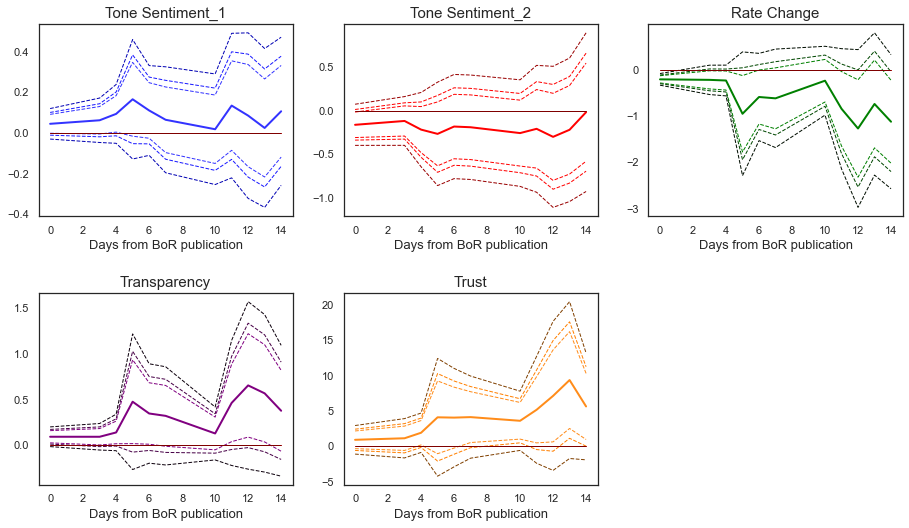

In [270]:
#reading stata output
num_of_regressors = 6

for normal_name in ["RUCBITR"]:
    dfvis = pd.read_csv(os.path.join(materials_folder + f"/stata_tables/{normal_name}_dem_res.csv"), encoding="utf-8", sep="=")
    dfvis = dfvis.iloc[:-2, 1:].reset_index(drop=True)
    dfvis.columns = ["name"] + [f'{i}' for i in range(0,15)]
    for col in dfvis:
        dfvis[col] = dfvis[col].str.replace(",","")
        dfvis[col] = dfvis[col].str.replace("*","")
        dfvis[col] = dfvis[col].str.replace("(","")
        dfvis[col] = dfvis[col].str.replace(")","")
    res_names = []
    for i in dfvis['name'][:-1]:
        if i:
            res_names.append(i)
            res_names.append(i + "_std")
    res_names.append("N")
    dfvis['name'] = res_names
    dfvis = dfvis.T
    dfvis.columns = dfvis.iloc[0]
    dfvis = dfvis.iloc[1:]
    for col in dfvis:
        dfvis[col] = dfvis[col].apply(lambda x: "0" if x == '.' else x)
        dfvis[col] = dfvis[col].astype(float)
    dfvis['df'] = dfvis['N'] - 1 - (num_of_regressors-1)
    dfvis = dfvis[dfvis.df > 1]
    dfvis.index = dfvis.index.astype(int)
    dfvis['t90'] = tstat.ppf((1 + .90) / 2., dfvis['df'])
    dfvis['t95'] = tstat.ppf((1 + .95) / 2., dfvis['df'])
    dfvis['t99'] = tstat.ppf((1 + .99) / 2., dfvis['df'])
    drawer(normal_name, dfvis)

# Summary statistics for the outcome variables

In [143]:
def corr(name):
    df_test = pd.read_csv(os.path.join(data_folder + name), encoding="utf-8", sep=";")
    df_test.date = pd.to_datetime(df_test.date).dt.date
    spread_col = [i for i in df_test.columns if i.find("spread") > -1][0]
    return [df_test[spread_col].corr(df_test[i]) for i in reg_cols]

names = ["/final01_normalized.csv",
        "/final11_normalized.csv",
        "/final21_normalized.csv",
        "/final_RGBITR_normalized.csv",
        "/final_RUCBITR_normalized.csv",
        "/final_RUGBITR1Y_normalized.csv",
        "/final_RUGBITR3Y_normalized.csv",
        "/final_RUGBITR5Y_normalized.csv",
        "/final_RUGBITR10Y_normalized.csv",
        "/final_RUABITR_normalized.csv"]
normal_names = ["MOEX",
        "RTSI",
        "FXGD ETF",
        "RGBITR",
        "RUCBITR",
        "RUGBITR1Y",
        "RUGBITR3Y",
        "RUGBITR5Y",
        "RUGBITR10Y",
        "RUABITR"]
# res = [[i] + corr(i) for i in names]
# df_res = pd.DataFrame(res).T
# df_res = df_res.iloc[1:]
# df_res.columns = normal_names
# df_res.index = ["toneev",
#                 "tonepr",
#                 "rate\\_shock\\_abs",
#                 "trans",
#                 "trust"]
name = names[0]
df_test = pd.read_csv(os.path.join(data_folder + name), encoding="utf-8", sep=";")
df_test.date = pd.to_datetime(df_test.date).dt.date
df_test[~df_test.toneev.isna()][['date', 'tonepr','toneev', 'moex_spread']].describe()

,tonepr,toneev,moex_spread
count,40.000000,40.000000,40.000000
mean,-5.964935,-9.738274,-0.193039
std,0.609159,1.000000,0.743202
min,-7.684616,-11.273283,-2.230029
25%,-6.175640,-10.279801,-0.624200
50%,-5.811413,-9.914626,-0.143456
75%,-5.583799,-9.193201,0.223492
max,-4.922596,-7.212115,1.170453


In [178]:
df_overall = pd.DataFrame()

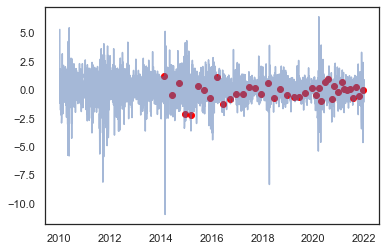

In [185]:
df_temp = file_names[0]
df_temp = df_temp[df_temp.TRADEDATE < datetime.date(2021, 12, 31)]

plt.plot(df_temp.TRADEDATE, (df_temp.SPREAD*100), alpha=0.5)
df_temp = df_temp[df_temp.TRADEDATE.isin(df_test[~df_test.toneev.isna()].date)]
plt.scatter(df_temp.TRADEDATE, (df_temp.SPREAD*100), color='red')
df_overall = df_temp[['TRADEDATE','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"MOEX"})

In [1]:
# df_temp = file_names[1]
# df_temp = df_temp[df_temp.TRADEDATE < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.TRADEDATE, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.TRADEDATE.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.TRADEDATE, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['TRADEDATE','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RTS"}),
#                       how='outer', left_on='date', right_on='date')

In [2]:
# df_temp = file_names[2]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"FXGD"}),
#                       how='outer', left_on='date', right_on='date')

In [3]:
# df_temp = file_names[3]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RGBITR"}),
#                       how='outer', left_on='date', right_on='date')

In [5]:
# df_temp = file_names[4]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUCBITR"}),
#                       how='outer', left_on='date', right_on='date')

In [6]:
# df_temp = file_names[5]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUGBITR1Y"}),
#                       how='outer', left_on='date', right_on='date')

In [7]:
# df_temp = file_names[6]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUGBITR3Y"}),
#                       how='outer', left_on='date', right_on='date')

In [8]:
# df_temp = file_names[7]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUGBITR5Y"}),
#                       how='outer', left_on='date', right_on='date')

In [9]:
# df_temp = file_names[8]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]

# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUGBITR10Y"}),
#                       how='outer', left_on='date', right_on='date')

In [10]:
# df_temp = file_names[9]
# df_temp = df_temp[df_temp.date < datetime.date(2021, 12, 31)]
# plt.plot(df_temp.date, (df_temp.SPREAD*100), alpha=0.5)
# df_temp = df_temp[df_temp.date.isin(df_test[~df_test.toneev.isna()].date)]
# plt.scatter(df_temp.date, (df_temp.SPREAD*100), color='red')
# df_overall = pd.merge(df_overall, df_temp[['date','SPREAD']].rename(columns={'TRADEDATE': 'date', "SPREAD":"RUABITR"}),
#                       how='outer', left_on='date', right_on='date')

In [216]:
df_sum_stats = df_overall.describe().T.round(4)
df_sum_stats.iloc[:, 0] = df_sum_stats.iloc[:, 0].astype(int)
print(df_sum_stats.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
\midrule
MOEX       &     40 & -0.1930 &  0.7432 & -2.2300 & -0.6242 & -0.1435 &  0.2235 &  1.1705 \\
RTS        &     40 & -0.3869 &  1.1293 & -3.7538 & -1.1094 & -0.2182 &  0.4393 &  1.6204 \\
FXGD       &     40 &  0.0028 &  1.0272 & -3.3081 & -0.6860 &  0.1064 &  0.5629 &  2.0748 \\
RGBITR     &     40 &  0.0439 &  0.4219 & -0.8166 & -0.1320 &  0.0517 &  0.1463 &  2.0852 \\
RUCBITR    &     40 &  0.0735 &  0.2016 & -0.1731 & -0.0313 &  0.0177 &  0.1206 &  0.8483 \\
RUGBITR1Y  &     40 &  0.0292 &  0.0633 & -0.1539 &  0.0000 &  0.0383 &  0.0625 &  0.1471 \\
RUGBITR3Y  &     40 & -0.0521 &  0.2359 & -1.1802 & -0.0843 &  0.0162 &  0.0755 &  0.2117 \\
RUGBITR5Y  &     40 & -0.1149 &  0.3524 & -1.8063 & -0.1694 &  0.0040 &  0.0774 &  0.3078 \\
RUGBITR10Y &     40 & -0.2310 &  0.5344 & -1.9699 & -0.3489 & -0.0848 &  0.0776 &  0.6713 \\
RUABITR    &     40 & -0.1067 